# Effyis DATALAB CHALLENGE23: Transaction's forecast : Fintech Client Transaction Forecasting Challenge

The objective is to develop a robust forecasting model that predicts total daily transaction amounts based on historical data. The provided dataset includes transaction details such as date, client account ID, transaction amount, and category. 

In [373]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/transactions-forecast1/train_test_data.csv


**Uploading data**

In [374]:
data = pd.read_csv('/kaggle/input/transactions-forecast1/train_test_data.csv')
data

,Date,Id_compte,amount_transaction,category_transaction
0,01/01/2022 00:23,SEWC_CL.1,462.96,Food & Drink - Groceries
1,01/01/2022 00:26,SEW0C_LI.1,15.51,General Services - Home Repair + Maintenance
2,01/01/2022 01:01,US.1,2.24,Bank Transfers - ATM withdrawals
3,01/01/2022 01:21,TA.1,2.86,Transportation - Public Transport
4,01/01/2022 01:54,US.1,1.68,Bank Transfers - ATM withdrawals
...,...,...,...,...
20406,07/11/2022 05:42,SEWC_P.1,264.60,Medical - Pharmacies and supplements
20407,07/11/2022 05:56,SEWC_CL.1,4.63,Bank Transfers - ATM fees
20408,07/11/2022 06:36,SEWC_PA.1,6.96,Transportation - Parking
20409,07/11/2022 06:37,SEW0C_HI.1,448.44,Subscription - Others


**Understanding the data structure**

In [375]:
# Data dimensions
data.shape

(20411, 4)

In [376]:
# Missing values 
data.isnull().sum()

Date                    0
Id_compte               0
amount_transaction      0
category_transaction    0
dtype: int64

In [377]:
# Descriptive statistics of the numerical columns
data.describe()

,amount_transaction
count,20411.000000
mean,56.955119
std,150.401661
min,0.230000
25%,2.790000
50%,4.700000
75%,8.790000
max,2005.200000


In [378]:
# The distinct values found in the 'category_transaction' column
distinct_values = data['category_transaction'].unique()
print(distinct_values)

['Food & Drink - Groceries' 'General Services - Home Repair + Maintenance'
 'Bank Transfers - ATM withdrawals' 'Transportation - Public Transport'
 'Bank Transfers - ATM fees' 'Food & Drink - Coffee and tea'
 'Subscription - Others' 'Transportation - Tolls'
 'Food & Drink - Fast food' 'Food & Drink - Vending machines'
 'Transportation - Parking' 'Medical - Pharmacies and supplements'
 'Rent & Utilities - Internet' 'Bank Transfers - Other bank fees'
 'Food & Drink - Restaurants' 'Transportation - Gas'
 'General Services  - Cloud storage' 'Transportation-Taxis and rideshares'
 'Supermarkets - Groceries' 'Bank Transfers - Overdraft fees'
 'Entertainment - Amusement Parks' 'Entertainment - TV and movies'
 'Rent & Utilities - Mobile Phone' 'Loans - Credit card payment'
 'Rent & Utilities - Water' 'General Merchandise  - Other'
 'General Services - Other non-entertainment online subscriptions'
 'General Merchandise - Clothing' 'Loans - Car loan payments'
 'General Merchandise - Books' 'Rent 

In [379]:
# Splitting the values in the 'category_transaction' column into two separate columns
split_columns = data['category_transaction'].str.split('-', n=1, expand=True)
data['Category of transaction'] = split_columns[0]
data['Type of transaction'] = split_columns[1]

data.drop('category_transaction', axis=1, inplace=True)
data.head()

,Date,Id_compte,amount_transaction,Category of transaction,Type of transaction
0,01/01/2022 00:23,SEWC_CL.1,462.96,Food & Drink,Groceries
1,01/01/2022 00:26,SEW0C_LI.1,15.51,General Services,Home Repair + Maintenance
2,01/01/2022 01:01,US.1,2.24,Bank Transfers,ATM withdrawals
3,01/01/2022 01:21,TA.1,2.86,Transportation,Public Transport
4,01/01/2022 01:54,US.1,1.68,Bank Transfers,ATM withdrawals


In [380]:
# Create a LabelEncoder instance
le = LabelEncoder()

# Fit and transform the 'Category of transaction' column in the data DataFrame
data['Category_encoded'] = le.fit_transform(data['Category of transaction'])

# Display the mapping between original and encoded values
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Mapping:", mapping)


# Display the updated DataFrame with the transformed data
print("Updated DataFrame:")
print(data[['Category of transaction', 'Category_encoded']])

Mapping: {'Bank Transfers ': 0, 'Credit card payment': 1, 'Entertainment ': 2, 'Entertainment  ': 3, 'Food & Drink ': 4, 'General Merchandise ': 5, 'General Merchandise  ': 6, 'General Services ': 7, 'General Services  ': 8, 'Government + Non': 9, 'Income ': 10, 'Loans ': 11, 'Medical ': 12, 'Rent & Utilities ': 13, 'Subscription ': 14, 'Supermarkets ': 15, 'Transportation': 16, 'Transportation ': 17, 'Travel ': 18, 'Travel  ': 19}
Updated DataFrame:
      Category of transaction  Category_encoded
0               Food & Drink                  4
1           General Services                  7
2             Bank Transfers                  0
3             Transportation                 17
4             Bank Transfers                  0
...                       ...               ...
20406                Medical                 12
20407         Bank Transfers                  0
20408         Transportation                 17
20409           Subscription                 14
20410         Ban

In [381]:
# Fit and transform the 'Type of transaction' column in the data DataFrame
data['Type_encoded'] = le.fit_transform(data['Type of transaction'])

# Display the mapping between original and encoded values
mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Mapping:", mapping)


# Display the updated DataFrame with the transformed data
print("Updated DataFrame:")
print(data[['Type of transaction', 'Type_encoded']])

Mapping: {' ATM fees': 0, ' ATM withdrawals': 1, ' Alcohol & Bars': 2, ' Amusement Parks': 3, ' Auto insurance': 4, ' Automobile maintenance and fees': 5, ' Banking rewards': 6, ' Books': 7, ' Car loan payments': 8, ' Casinos and gambling': 9, ' Clothing': 10, ' Cloud storage': 11, ' Coffee and tea': 12, ' Credit card payment': 13, ' Education': 14, ' Electronics': 15, ' Fast food': 16, ' Flights': 17, ' Food delivery': 18, ' Foreign transaction fees': 19, ' Gas': 20, ' Groceries': 21, ' Health + Fitness': 22, ' Health insurance': 23, ' Home Repair + Maintenance': 24, ' Houseware': 25, ' Internet': 26, ' Lodging': 27, ' Mobile Phone': 28, ' Mortgage payments ': 29, ' Online Marketplaces': 30, ' Other': 31, ' Other Insurance': 32, ' Other bank fees': 33, ' Other non - entertainment online subscriptions': 34, ' Other non-entertainment online subscriptions': 35, ' Others': 36, ' Overdraft fees': 37, ' Parking': 38, ' Personal loans': 39, ' Pet supplies': 40, ' Pharmacies and supplements':

In [382]:
# Encoding 'Id_compte' as it is a categorical feature
data['Id_compte_encoded'] = le.fit_transform(data['Id_compte'])

In [383]:
# Dropping unused columns 
columns_to_drop = ['Id_compte', 'Type of transaction', 'Category of transaction']
data = data.drop(columns=columns_to_drop)

data.head()

,Date,amount_transaction,Category_encoded,Type_encoded,Id_compte_encoded
0,01/01/2022 00:23,462.96,4,21,6
1,01/01/2022 00:26,15.51,7,24,5
2,01/01/2022 01:01,2.24,0,1,11
3,01/01/2022 01:21,2.86,17,43,10
4,01/01/2022 01:54,1.68,0,1,11


In [384]:
# Convert 'Date' column to string
data['Date'] = data['Date'].astype(str)

# Split the 'Date' column into 'date' and 'time'
split_columns = data['Date'].str.split(' ', n=1, expand=True)
data['date'] = split_columns[0]
data['time'] = split_columns[1]

data.drop('Date', axis=1, inplace=True)

data.head()

,amount_transaction,Category_encoded,Type_encoded,Id_compte_encoded,date,time
0,462.96,4,21,6,01/01/2022,00:23
1,15.51,7,24,5,01/01/2022,00:26
2,2.24,0,1,11,01/01/2022,01:01
3,2.86,17,43,10,01/01/2022,01:21
4,1.68,0,1,11,01/01/2022,01:54


In [385]:
# Create time series features based on time series index.
def create_features(data):

    data = data.copy()

    # Convert 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

    data['dayofweek'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    data['dayofmonth'] = data['date'].dt.day
    
    '''
    #data['weekofyear'] = data['date'].dt.isocalendar().week
    #data['quarter'] = data['date'].dt.quarter
    #data['dayofyear'] = data['date'].dt.dayofyear"
    '''
    
    return data

data = create_features(data)

data.drop('time', axis=1, inplace=True)
data.head(10)

,amount_transaction,Category_encoded,Type_encoded,Id_compte_encoded,date,dayofweek,month,year,dayofmonth
0,462.96,4,21,6,2022-01-01,5,1,2022,1
1,15.51,7,24,5,2022-01-01,5,1,2022,1
2,2.24,0,1,11,2022-01-01,5,1,2022,1
3,2.86,17,43,10,2022-01-01,5,1,2022,1
4,1.68,0,1,11,2022-01-01,5,1,2022,1
5,2.93,17,43,2,2022-01-01,5,1,2022,1
6,5.86,0,0,1,2022-01-01,5,1,2022,1
7,7.47,4,12,4,2022-01-01,5,1,2022,1
8,5.85,17,43,2,2022-01-01,5,1,2022,1
9,703.44,14,36,1,2022-01-01,5,1,2022,1


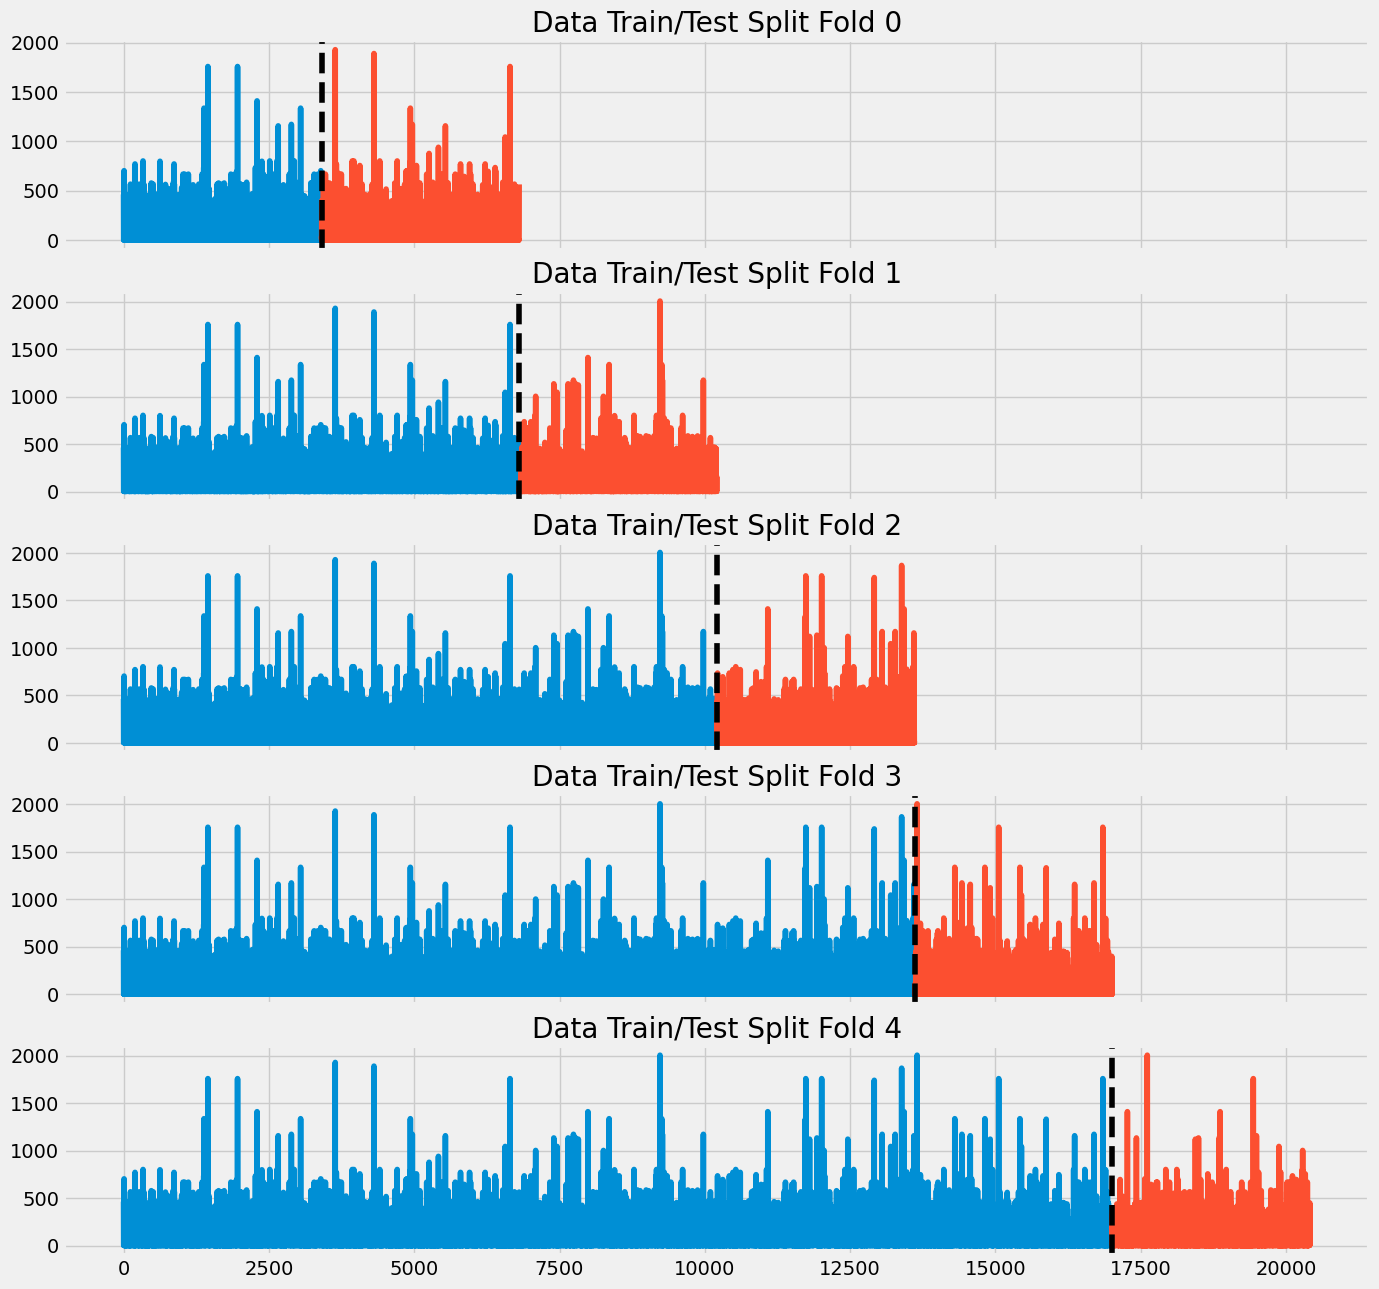

In [386]:
# Splitting data into train and test using cross validation method

split_data = TimeSeriesSplit(n_splits=5)
data = data.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0

for train_index, test_index in split_data.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    
    FEATURES = ['Category_encoded', 'Type_encoded', 'Id_compte_encoded',
                'month','year','dayofmonth','dayofweek']
    TARGET = 'amount_transaction'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    train['amount_transaction'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['amount_transaction'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [387]:
# Application of the XGBoost model
preds = []
scores = []
for train_index, test_index in split_data.split(data):
    reg = xgb.XGBRegressor(base_score=1, booster='gbtree',    
                           n_estimators=700,
                           early_stopping_rounds=100,
                           objective='reg:linear',
                           max_depth=5,
                           learning_rate=0.04,
                           subsample= 0.8552,
                           colsample_bytree= 0.8552,
                           gamma= 0.6,
                           min_child_weight= 4,
                           reg_alpha= 0.06,
                           reg_lambda= 1)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
print ('---------------------------------------------------------------------')
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

[0]	validation_0-rmse:158.04154	validation_1-rmse:153.08958
[100]	validation_0-rmse:59.03095	validation_1-rmse:61.99845
[200]	validation_0-rmse:43.02500	validation_1-rmse:48.57838
[300]	validation_0-rmse:38.29536	validation_1-rmse:45.17230
[400]	validation_0-rmse:35.77648	validation_1-rmse:44.41817
[500]	validation_0-rmse:34.19286	validation_1-rmse:43.90181
[600]	validation_0-rmse:32.66903	validation_1-rmse:43.64401
[699]	validation_0-rmse:31.61722	validation_1-rmse:43.50423
[0]	validation_0-rmse:158.04154	validation_1-rmse:153.08958
[100]	validation_0-rmse:59.03095	validation_1-rmse:61.99845
[200]	validation_0-rmse:43.02500	validation_1-rmse:48.57838
[300]	validation_0-rmse:38.29536	validation_1-rmse:45.17230
[400]	validation_0-rmse:35.77648	validation_1-rmse:44.41817
[500]	validation_0-rmse:34.19286	validation_1-rmse:43.90181
[600]	validation_0-rmse:32.66903	validation_1-rmse:43.64401
[699]	validation_0-rmse:31.61722	validation_1-rmse:43.50423
[0]	validation_0-rmse:158.04154	validati

In [388]:
# Generating Predictions for the Evaluation Period
# Creating a dataframe for prediction dates
prediction_dates = pd.date_range(start='2022-11-08', end='2022-12-31')

# Create the prediction_data DataFrame
prediction_data = pd.DataFrame({
    'date': np.repeat(prediction_dates, len(le.classes_)),
    'Id_compte_encoded': np.tile(le.transform(le.classes_), len(prediction_dates)),
    'Category_encoded': np.tile(le.transform(le.classes_), len(prediction_dates)),
    'Type_encoded': np.tile(le.transform(le.classes_), len(prediction_dates))
})

prediction_data = create_features(prediction_data)

# Display the modified prediction_data
prediction_data

,date,Id_compte_encoded,Category_encoded,Type_encoded,dayofweek,month,year,dayofmonth
0,2022-11-08,0,0,0,1,11,2022,8
1,2022-11-08,1,1,1,1,11,2022,8
2,2022-11-08,2,2,2,1,11,2022,8
3,2022-11-08,3,3,3,1,11,2022,8
4,2022-11-08,4,4,4,1,11,2022,8
...,...,...,...,...,...,...,...,...
643,2022-12-31,7,7,7,5,12,2022,31
644,2022-12-31,8,8,8,5,12,2022,31
645,2022-12-31,9,9,9,5,12,2022,31
646,2022-12-31,10,10,10,5,12,2022,31


In [389]:
# Evaluation of the model 
ft_pred = prediction_data[['Category_encoded', 'Type_encoded', 'Id_compte_encoded', 
                           'month','year','dayofmonth','dayofweek']]
amounts_pred = reg.predict(ft_pred)
prediction_data['Predicted_Amount'] = amounts_pred

prediction_data['ID'] = prediction_data['date'].dt.strftime('%Y-%m-%d') + '_' + le.inverse_transform(prediction_data['Id_compte_encoded'])

final_output = prediction_data[['ID', 'Predicted_Amount']].reset_index(drop=True)

final_output

,ID,Predicted_Amount
0,2022-11-08_CPA.1,2.928847
1,2022-11-08_CPA_MP.1,275.379639
2,2022-11-08_HP.1,402.515686
3,2022-11-08_IPA.1,509.424225
4,2022-11-08_SEW0C_HI.1,489.008423
...,...,...
643,2022-12-31_SEWC_P.1,936.160217
644,2022-12-31_SEWC_PA.1,863.281677
645,2022-12-31_SEWC_P_PL.1,652.552368
646,2022-12-31_TA.1,414.337708


In [390]:
final_output.to_csv('final_output_predictions8.csv', index=False)

# Interpretation

    The provided code outlines the approach to address the Fintech Client Transaction Forecasting Challenge, focusing on data preprocessing, exploratory data analysis (EDA), and the implementation of an XGBoost forecasting model. 
    The XGBoost algorithm, as configured and trained in the provided code, demonstrates a capability to make predictions on daily transaction amounts with an average RMSE of 43.4105.
    